### **GOP Debate Twitter Sentiment Analysis**

![alt text](https://ca-times.brightspotcdn.com/dims4/default/a996972/2147483647/strip/true/crop/1600x900+0+0/resize/840x473!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fc7%2Faa%2F6781933c2e4b1475a4f6f70acdb2%2Fla-na-gop-debate-20150806-001)

**Install Library Tambahan**

In [1]:
!pip install jcopml

     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33231 sha256=4496481447535f5be9b2cd03461f98c0a4faf07684e933afc07a772833193d51
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


**Import library and Dataset**

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from subprocess import check_output

In [65]:
df = pd.read_csv(r'Sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


### **Data Exploration**

In [66]:
print(f'Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom')

Dataset memiliki 13871 baris dan 21 kolom


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [68]:
df.isnull().sum().sum()

77978

Terdapat 77978 missing values

In [69]:
from jcopml.plot import plot_missing_value

,missing_value,%
id,0,0.00
candidate,96,0.69
candidate_confidence,0,0.00
relevant_yn,0,0.00
relevant_yn_confidence,0,0.00
sentiment,0,0.00
sentiment_confidence,0,0.00
subject_matter,326,2.35
subject_matter_confidence,0,0.00
candidate_gold,13843,99.80


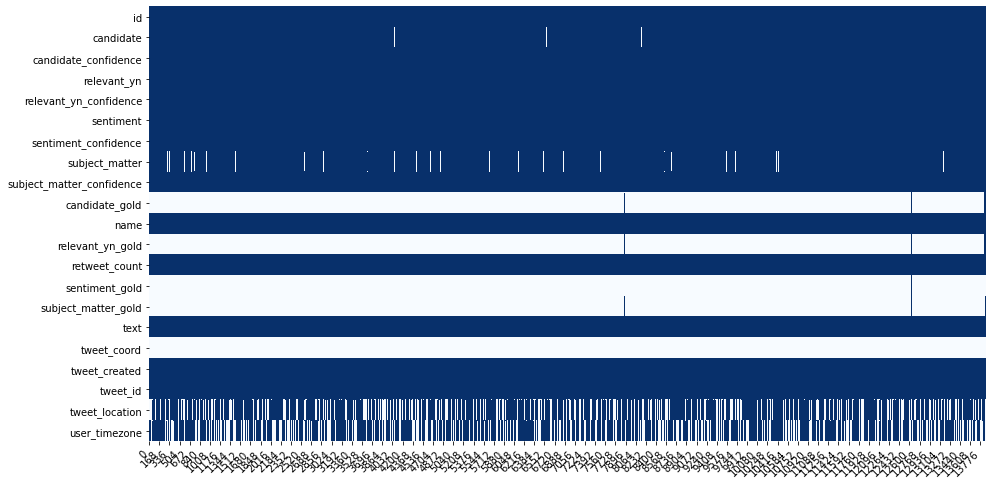

In [70]:
plot_missing_value(df, return_df=True)

Kita akan menghapus kolom dengan missing values > 90%

In [71]:
df.drop(['candidate_gold', 'relevant_yn_gold', 'sentiment_gold', 'subject_matter_gold', 'tweet_coord'], axis=1, inplace=True)
print(df.isnull().sum())
df.shape

id                              0
candidate                      96
candidate_confidence            0
relevant_yn                     0
relevant_yn_confidence          0
sentiment                       0
sentiment_confidence            0
subject_matter                326
subject_matter_confidence       0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
tweet_id                        0
tweet_location               3912
user_timezone                4403
dtype: int64


(13871, 16)

In [72]:
df.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


In [73]:
sentiment = df['sentiment'].value_counts()

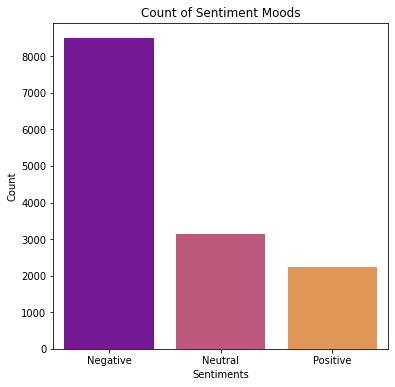

In [74]:
plt.figure(figsize=(6, 6))
sns.barplot(x=sentiment[:].index, y=sentiment[:].values, palette='plasma')
plt.title('Count of Sentiment Moods')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.show()

Mayoritas sentimen berisi sentimen negatif

In [75]:
candidate = df['candidate'].value_counts()

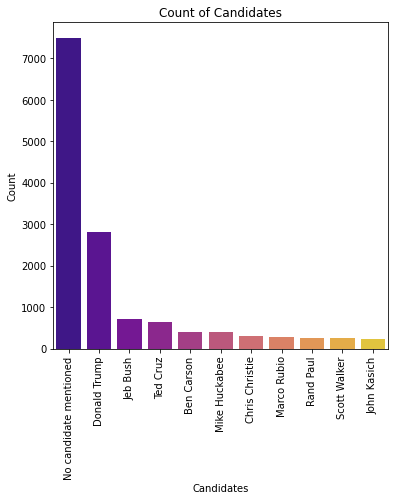

In [76]:
plt.figure(figsize=(6, 6))
sns.barplot(x=candidate[:].index, y=candidate[:].values, palette='plasma')
plt.title('Count of Candidates')
plt.ylabel('Count')
plt.xlabel('Candidates')
plt.xticks(rotation=90)
plt.show()

In [77]:
df['candidate'].nunique()

11

Terdapat 10 kandidat. Kandidat mayoritas tidak disebutkan namanya namun berdasarkan nama kandidat yang terdaftar, nama Donald Trump merupakan nama kandidat yang paling banyak muncul

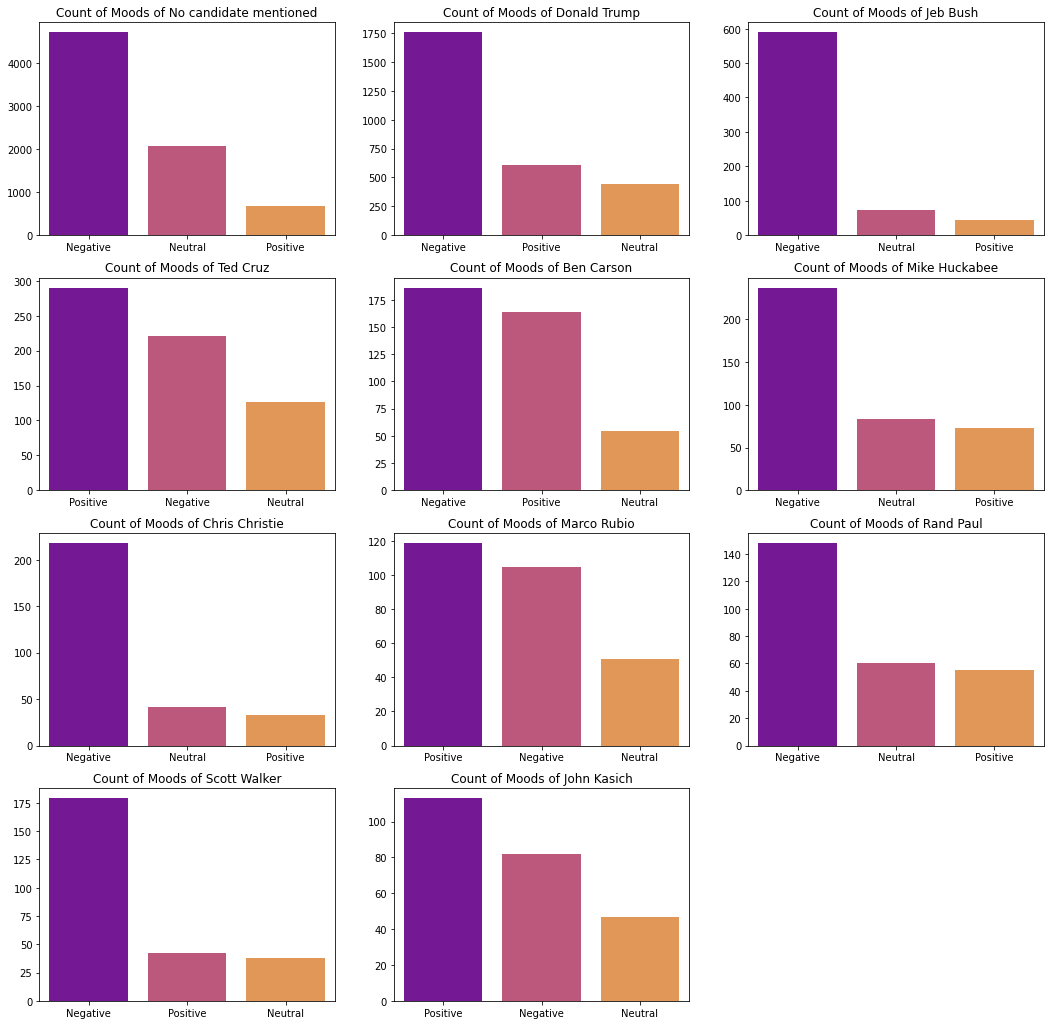

In [78]:
def plot_moods_of_candidate(Candidate):
    data = df[df['candidate']==Candidate]
    count = data['sentiment'].value_counts()
    sns.barplot(x=count[:].index, y=count[:].values, order=count.index, palette='plasma')
    plt.title('Count of Moods of ' + Candidate)

plt.figure(1, figsize=(18, 18))
plt.subplot(4, 3, 1)
plot_moods_of_candidate('No candidate mentioned')
plt.subplot(4, 3, 2)
plot_moods_of_candidate('Donald Trump')
plt.subplot(4, 3, 3)
plot_moods_of_candidate('Jeb Bush')
plt.subplot(4, 3, 4)
plot_moods_of_candidate('Ted Cruz')
plt.subplot(4, 3, 5)
plot_moods_of_candidate('Ben Carson')
plt.subplot(4, 3, 6)
plot_moods_of_candidate('Mike Huckabee')
plt.subplot(4, 3, 7)
plot_moods_of_candidate('Chris Christie')
plt.subplot(4, 3, 8)
plot_moods_of_candidate('Marco Rubio')
plt.subplot(4, 3, 9)
plot_moods_of_candidate('Rand Paul')
plt.subplot(4, 3, 10)
plot_moods_of_candidate('Scott Walker')
plt.subplot(4, 3, 11)
plot_moods_of_candidate('John Kasich')

Dari plot diatas dapat dilihat bahwa selain Ted Cruz, Marco Rubio, dan John Kasich, kandidat lain mendapatkan mayoritas sentiment negatif di Twitter

In [79]:
df['subject_matter'].nunique()

12

In [80]:
df['subject_matter'].value_counts()

None of the above                       8148
FOX News or Moderators                  2900
Religion                                 407
Foreign Policy                           366
Women's Issues (not abortion though)     362
Racial issues                            353
Abortion                                 293
Jobs and Economy                         251
Immigration                              211
LGBT issues                              126
Healthcare (including Medicare)           67
Gun Control                               61
Name: subject_matter, dtype: int64

In [81]:
def SM_Count(Candidate):
    if Candidate=='All':
        data = df
    else:
        data = df[df['candidate']==Candidate]
    count = data['subject_matter'].value_counts()
    return count

In [82]:
def plot_subject_matter(Candidate):
    data = SM_Count(Candidate)
    sns.barplot(x=data[:].index, y=data[:].values, palette='plasma')
    plt.xticks(rotation=90)
    plt.title('Count of Subject Matter of ' + Candidate)

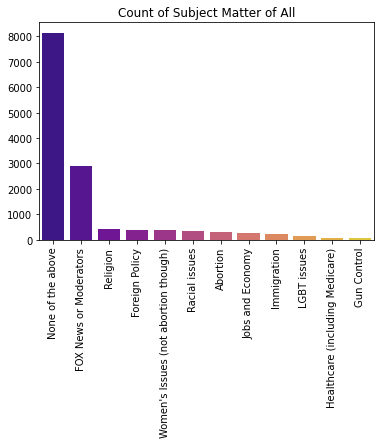

In [83]:
plot_subject_matter('All')

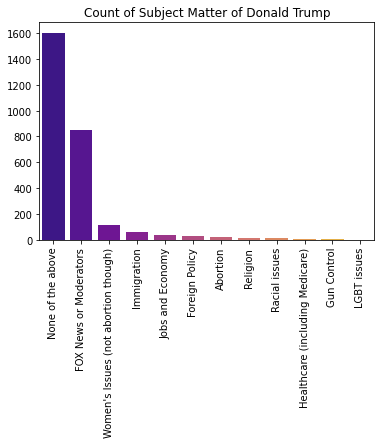

In [84]:
plot_subject_matter('Donald Trump')

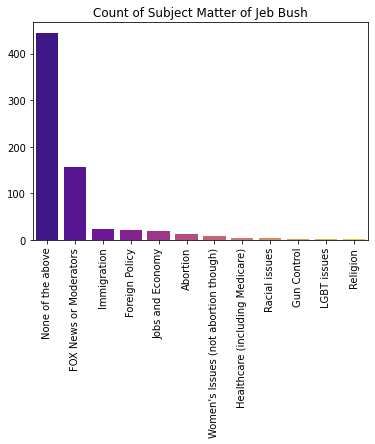

In [85]:
plot_subject_matter('Jeb Bush')

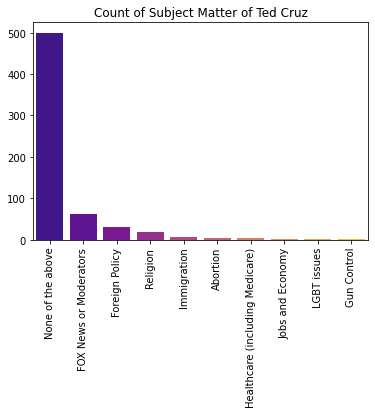

In [86]:
plot_subject_matter('Ted Cruz')

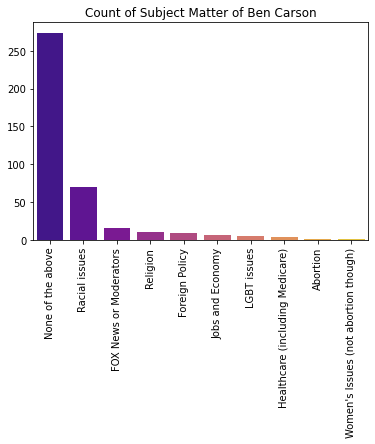

In [87]:
plot_subject_matter('Ben Carson')

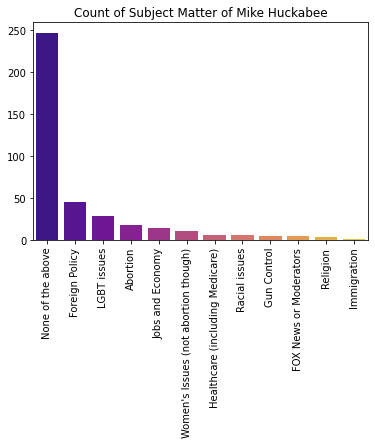

In [88]:
plot_subject_matter('Mike Huckabee')

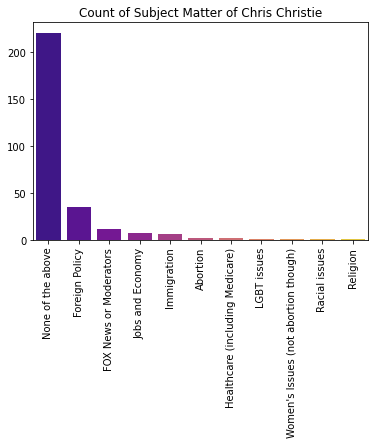

In [89]:
plot_subject_matter('Chris Christie')

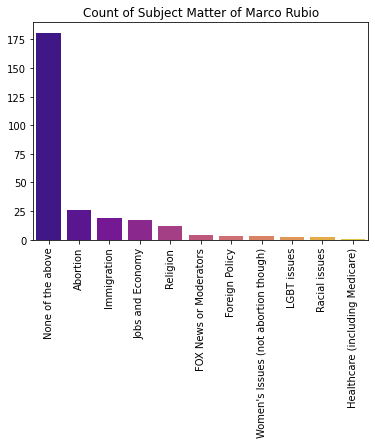

In [90]:
plot_subject_matter('Marco Rubio')

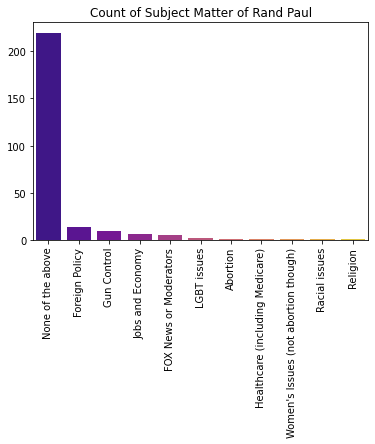

In [91]:
plot_subject_matter('Rand Paul')

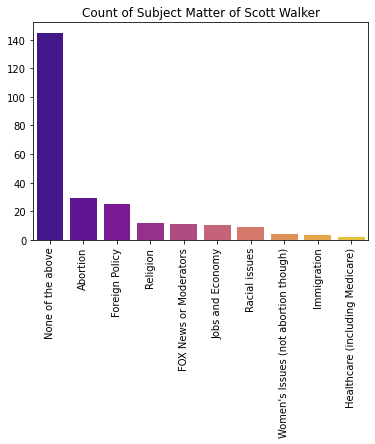

In [92]:
plot_subject_matter('Scott Walker')

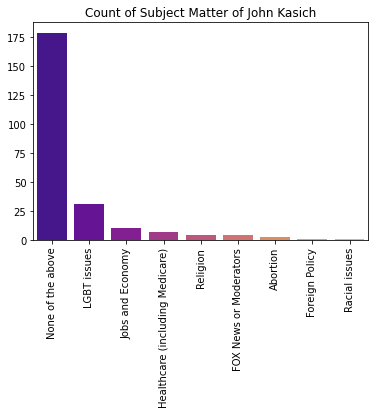

In [93]:
plot_subject_matter('John Kasich')

Positive words


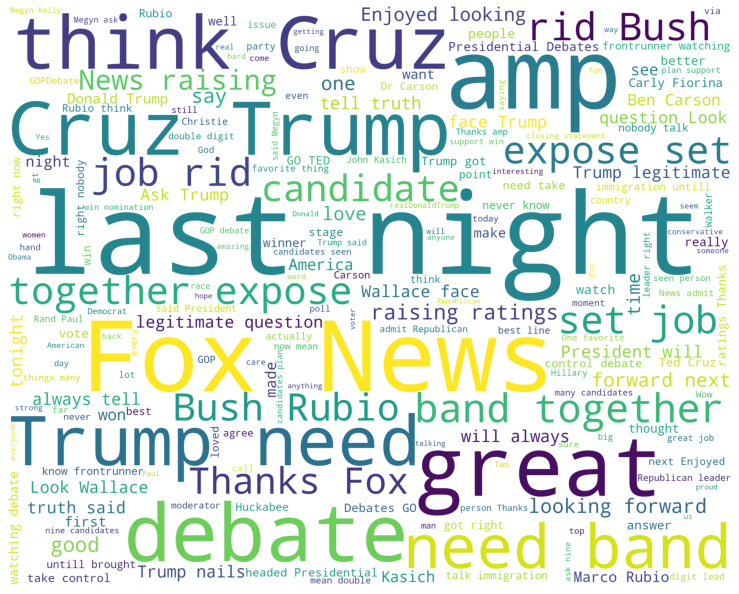

Neutral words


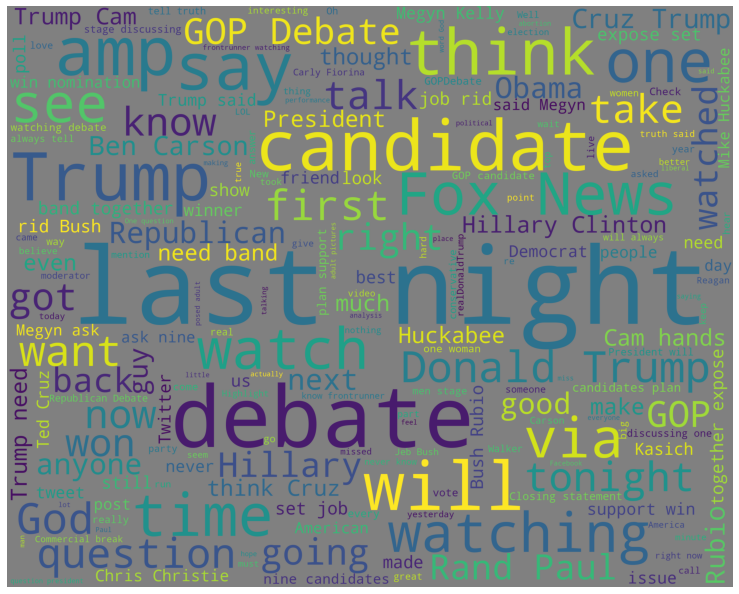

Negative words


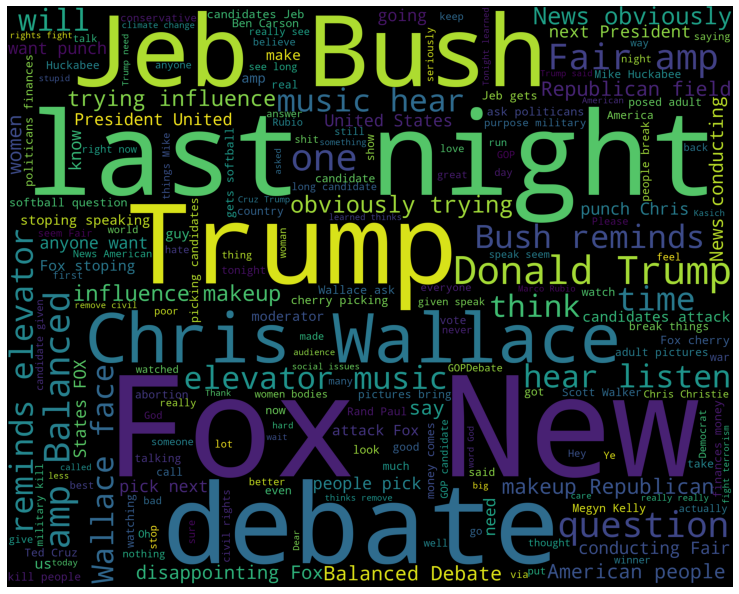

In [95]:
data_pos = df[df['sentiment'] == 'Positive']
data_pos = data_pos['text']
data_neutral = df[df['sentiment'] == 'Neutral']
data_neutral = data_neutral['text']
data_neg = df[df['sentiment'] == 'Negative']
data_neg = data_neg['text']

def wordcloud_draw(data, color='black'):
    words = ' '.join(data)
    cleaned_word = ' '.join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color=color, 
                          width=2500, 
                          height=2000
                         ).generate(cleaned_word)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print('Positive words')
wordcloud_draw(data_pos, 'white')
print('Neutral words')
wordcloud_draw(data_neutral, 'grey')
print('Negative words')
wordcloud_draw(data_neg)

### **Data Preprocessing**

**Count Common and Rare Words**

In [96]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq

RT             7833
the            7795
#GOPDebate     7541
to             4647
#GOPDebates    4317
of             3298
a              3045
is             3012
and            2695
I              2356
dtype: int64

In [97]:
rare = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
rare

ride:                     1
Klux                      1
@imuszero:                1
Dems'                     1
http://t.co/v4wnjcy9Sw    1
Rosie?                    1
@aubreysitterson:         1
hired…                    1
@TeamKCP                  1
68%                       1
dtype: int64

**Removing RT**

In [98]:
rt = pd.Series(' '.join(df['text']).split()).value_counts()[:1]
rt

RT    7833
dtype: int64

In [99]:
rt = list(freq.index)

In [100]:
df['text'] = df['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in rt))
df[['text']].head()

,text
0,@NancyLeeGrahn: How did everyone feel about Cl...
1,@ScottWalker: Didn't catch full #GOPdebate las...
2,@TJMShow: No mention Tamir Rice was held in Cl...
3,@RobGeorge: That Carly Fiorina trending -- hou...
4,@DanScavino: w/ @realDonaldTrump delivered hig...


**Count number of words and characters**

In [101]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(' ')))
df[['text', 'word_count']].head()

,text,word_count
0,@NancyLeeGrahn: How did everyone feel about Cl...,12
1,@ScottWalker: Didn't catch full #GOPdebate las...,18
2,@TJMShow: No mention Tamir Rice was held in Cl...,10
3,@RobGeorge: That Carly Fiorina trending -- hou...,21
4,@DanScavino: w/ @realDonaldTrump delivered hig...,12


In [102]:
df['char_count'] = df['text'].str.len() #includes spaces
df[['text', 'char_count']].head()

,text,char_count
0,@NancyLeeGrahn: How did everyone feel about Cl...,88
1,@ScottWalker: Didn't catch full #GOPdebate las...,130
2,@TJMShow: No mention Tamir Rice was held in Cl...,59
3,@RobGeorge: That Carly Fiorina trending -- hou...,127
4,@DanScavino: w/ @realDonaldTrump delivered hig...,115


Kita telah menghitung jumlah kata dan karakter dari kolom 'text'. Jumlah karakter diatas termasuk juga spasi yang bisa kita hilangkan bila dibutuhkan

**Count number of Stopwords**

In [103]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [105]:
stop = stopwords.words('english')

In [106]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text', 'stopwords']].head()

,text,stopwords
0,@NancyLeeGrahn: How did everyone feel about Cl...,2
1,@ScottWalker: Didn't catch full #GOPdebate las...,3
2,@TJMShow: No mention Tamir Rice was held in Cl...,2
3,@RobGeorge: That Carly Fiorina trending -- hou...,6
4,@DanScavino: w/ @realDonaldTrump delivered hig...,1


### **Count number of special characters**

**1. Hashtags**

In [107]:
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text', 'hashtags']].head()

,text,hashtags
0,@NancyLeeGrahn: How did everyone feel about Cl...,0
1,@ScottWalker: Didn't catch full #GOPdebate las...,2
2,@TJMShow: No mention Tamir Rice was held in Cl...,0
3,@RobGeorge: That Carly Fiorina trending -- hou...,1
4,@DanScavino: w/ @realDonaldTrump delivered hig...,1


**2. At sign (@)**

In [108]:
df['At'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text', 'At']].head()

,text,At
0,@NancyLeeGrahn: How did everyone feel about Cl...,1
1,@ScottWalker: Didn't catch full #GOPdebate las...,1
2,@TJMShow: No mention Tamir Rice was held in Cl...,1
3,@RobGeorge: That Carly Fiorina trending -- hou...,1
4,@DanScavino: w/ @realDonaldTrump delivered hig...,2


Kita akan menghilangkan karakter selain huruf kecil dan huruf kapital lalu seluruh kata dibuat lowercase dan displit. Setelah itu stopwordsnya dihilangkan. Karena pada dataset ini memakai bahasa inggris, maka stopwordsnya pun diatur ke dalam bahasa inggris

In [109]:
import re

In [110]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return(' '.join(meaningful_words))

In [111]:
def clean_tweet_length(raw_tweet):
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return(len(meaningful_words))

In [112]:
df['num_sentiment'] = df['sentiment'].apply(lambda x: 0 if x=='Negative' else 1)
df[['sentiment', 'num_sentiment']].head()

,sentiment,num_sentiment
0,Neutral,1
1,Positive,1
2,Neutral,1
3,Positive,1
4,Positive,1


Untuk sentimen neutral kita asumsikan sama dengan positive

In [113]:
df['clean_tweet'] = df['text'].apply(lambda x: tweet_to_words(x))
df[['text', 'clean_tweet']].head()

,text,clean_tweet
0,@NancyLeeGrahn: How did everyone feel about Cl...,nancyleegrahn everyone feel climate change que...
1,@ScottWalker: Didn't catch full #GOPdebate las...,scottwalker catch full gopdebate last night sc...
2,@TJMShow: No mention Tamir Rice was held in Cl...,tjmshow mention tamir rice held cleveland wow
3,@RobGeorge: That Carly Fiorina trending -- hou...,robgeorge carly fiorina trending hours debate ...
4,@DanScavino: w/ @realDonaldTrump delivered hig...,danscavino w realdonaldtrump delivered highest...


In [114]:
df['tweet_length'] = df['text'].apply(lambda x: clean_tweet_length(x))
df[['text', 'word_count', 'clean_tweet', 'tweet_length']].head()

,text,word_count,clean_tweet,tweet_length
0,@NancyLeeGrahn: How did everyone feel about Cl...,12,nancyleegrahn everyone feel climate change que...,9
1,@ScottWalker: Didn't catch full #GOPdebate las...,18,scottwalker catch full gopdebate last night sc...,14
2,@TJMShow: No mention Tamir Rice was held in Cl...,10,tjmshow mention tamir rice held cleveland wow,7
3,@RobGeorge: That Carly Fiorina trending -- hou...,21,robgeorge carly fiorina trending hours debate ...,10
4,@DanScavino: w/ @realDonaldTrump delivered hig...,12,danscavino w realdonaldtrump delivered highest...,12


**Spelling Correction** 

Optional. Hanya coba-coba saja untuk saat ini

In [115]:
!pip install textblob

In [116]:
from textblob import TextBlob

In [117]:
ddf = df.copy()
print(ddf.shape)

(13871, 24)


In [118]:
def spell_correction(copy):
    ddf['clean_tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))
    return ddf[['clean_tweet']].head()

In [119]:
spell_correction(ddf)

,clean_tweet
0,nancyleegrahn everyone feel climate change que...
1,scottwalker catch full gopdebate last night sc...
2,tjmshow mention tamir rice held cleveland wow
3,robgeorge carly fiorina trending hours debate ...
4,danscavino w realdonaldtrump delivered highest...


### **Data Splitting**

In [120]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(train.shape)
print(test.shape)

(11096, 24)
(2775, 24)


In [121]:
train_clean_tweet = []
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
    
test_clean_tweet = []
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [123]:
v = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, stop_words='english')
train_features = v.fit_transform(train_clean_tweet)
test_features = v.transform(test_clean_tweet)

### **Data Training**

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [125]:
Classifiers = [
    LogisticRegression(C=0.00000001, solver='lbfgs', max_iter=200, random_state=42),
    KNeighborsClassifier(n_neighbors=3),
    SVC(C=0.025, kernel='rbf', probability=True, verbose=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=300),
    AdaBoostClassifier(),
    GaussianNB()
]

In [126]:
dense_features=train_features.toarray()
dense_test=test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['num_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['num_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['num_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy)) 

Accuracy of LogisticRegression is 0.6205405405405405
Accuracy of KNeighborsClassifier is 0.6187387387387387
[LibSVM]Accuracy of SVC is 0.6324324324324324
Accuracy of DecisionTreeClassifier is 0.6911711711711712
Accuracy of RandomForestClassifier is 0.7232432432432433
Accuracy of AdaBoostClassifier is 0.6875675675675675
Accuracy of GaussianNB is 0.5592792792792792


### **Comparing Count Vectorizer and Tf-Idf Vectorizer Performances**

**LinearSVC**

Vectorize using Count Vectorizer

In [127]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

In [128]:
cv_data = CountVectorizer(binary=True, ngram_range=(1, 3))
cv_train_features = cv_data.fit_transform(train_clean_tweet)
cv_test_features = cv_data.transform(test_clean_tweet)

In [129]:
#C = [0.005, 0.05, 0.5]
linear_svc_cv = LinearSVC(C=0.01, random_state=42)
linear_svc_cv.fit(cv_train_features, train['num_sentiment'])
predict_cv = linear_svc_cv.predict(cv_test_features)

In [130]:
print('Classification Report : \n', classification_report(test['num_sentiment'], predict_cv, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_cv))
print()
print('Accuracy: ', accuracy_score(test['num_sentiment'], predict_cv))

Classification Report : 
               precision    recall  f1-score   support

    Negative       0.75      0.86      0.80      1722
    Positive       0.70      0.54      0.61      1053

    accuracy                           0.74      2775
   macro avg       0.72      0.70      0.70      2775
weighted avg       0.73      0.74      0.73      2775

Confusion Matrix: 
 [[1478  244]
 [ 489  564]]

Accuracy:  0.7358558558558559


Using Tf-Idf Vectorizer

In [131]:
tfidf_data = TfidfVectorizer(ngram_range=(1, 3))
tfidf_train_features = tfidf_data.fit_transform(train_clean_tweet)
tfidf_test_features = tfidf_data.transform(test_clean_tweet)

In [132]:
linear_svc_tfidf = LinearSVC(C=0.5, random_state=42)
linear_svc_tfidf.fit(tfidf_train_features, train['num_sentiment'])
predict_tfidf = linear_svc_tfidf.predict(tfidf_test_features)

In [133]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_tfidf, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_tfidf))
print()
print('Accuracy: ', accuracy_score(test['num_sentiment'], predict_tfidf))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.78      0.79      0.79      1722
    Positive       0.65      0.64      0.65      1053

    accuracy                           0.73      2775
   macro avg       0.72      0.72      0.72      2775
weighted avg       0.73      0.73      0.73      2775

Confusion Matrix: 
 [[1364  358]
 [ 379  674]]

Accuracy:  0.7344144144144145


Linear SVC memakai Count Vectorizer memberikan nilai akurasi yang sedikit lebih baik yakni sebesar 0.7358

**Naive Bayes Classifier**

Using Count Vectorizer

In [134]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

**MultinomialNB**

In [135]:
cv_NB = CountVectorizer(ngram_range=(1, 1))
cv_train_features_NB = cv_NB.fit_transform(train_clean_tweet)
cv_test_features_NB = cv_NB.transform(test_clean_tweet)

In [136]:
cv_train_features_NB = cv_train_features_NB.toarray()
cv_test_features_NB = cv_test_features_NB.toarray()

print(cv_train_features_NB.shape)
print(cv_test_features_NB.shape)

(11096, 16513)
(2775, 16513)


In [137]:
multi_clf = MultinomialNB()
multi_clf.fit(cv_train_features_NB, train['num_sentiment'])
predict_MNB = multi_clf.predict(cv_test_features_NB)

In [138]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_MNB, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_MNB))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_MNB))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.78      0.81      0.80      1722
    Positive       0.67      0.63      0.65      1053

    accuracy                           0.74      2775
   macro avg       0.73      0.72      0.72      2775
weighted avg       0.74      0.74      0.74      2775

Confusion Matrix: 
 [[1392  330]
 [ 386  667]]

Accuracy: 
 0.741981981981982


**BernoulliNB**

In [139]:
multi_clf = BernoulliNB()
multi_clf.fit(cv_train_features_NB, train['num_sentiment'])
predict_NB = multi_clf.predict(cv_test_features_NB)

In [140]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_NB, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_NB))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_NB))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.76      0.84      0.80      1722
    Positive       0.69      0.57      0.62      1053

    accuracy                           0.74      2775
   macro avg       0.73      0.71      0.71      2775
weighted avg       0.74      0.74      0.73      2775

Confusion Matrix: 
 [[1455  267]
 [ 454  599]]

Accuracy: 
 0.7401801801801802


**GaussianNB**

In [141]:
multi_clf = GaussianNB()
multi_clf.fit(cv_train_features_NB, train['num_sentiment'])
predict_NB = multi_clf.predict(cv_test_features_NB)

In [142]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_NB, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_NB))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_NB))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.74      0.37      0.49      1722
    Positive       0.43      0.78      0.56      1053

    accuracy                           0.53      2775
   macro avg       0.58      0.58      0.52      2775
weighted avg       0.62      0.53      0.52      2775

Confusion Matrix: 
 [[ 636 1086]
 [ 229  824]]

Accuracy: 
 0.5261261261261261


Using Tf-Idf Vectorizer

In [143]:
tfidf_NB = TfidfVectorizer(ngram_range=(1, 1))
tfidf_train_features_NB = tfidf_NB.fit_transform(train_clean_tweet)
tfidf_test_features_NB = tfidf_NB.transform(test_clean_tweet)

**Multinomial NB**

In [144]:
multi_clf_NB = MultinomialNB()
multi_clf_NB.fit(tfidf_train_features_NB, train['num_sentiment'])
predict_NB_tfidf = multi_clf_NB.predict(tfidf_test_features_NB)

In [145]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_NB_tfidf, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_NB_tfidf))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_NB_tfidf))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.72      0.91      0.81      1722
    Positive       0.75      0.42      0.54      1053

    accuracy                           0.73      2775
   macro avg       0.73      0.67      0.67      2775
weighted avg       0.73      0.73      0.70      2775

Confusion Matrix: 
 [[1572  150]
 [ 611  442]]

Accuracy: 
 0.7257657657657658


**Bernoulli NB**

In [146]:
bernoulli_clf_NB = BernoulliNB()
bernoulli_clf_NB.fit(tfidf_train_features_NB, train['num_sentiment'])
predict_NB_tfidf = bernoulli_clf_NB.predict(tfidf_test_features_NB)

In [147]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_NB_tfidf, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_NB_tfidf))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_NB_tfidf))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.76      0.84      0.80      1722
    Positive       0.69      0.57      0.62      1053

    accuracy                           0.74      2775
   macro avg       0.73      0.71      0.71      2775
weighted avg       0.74      0.74      0.73      2775

Confusion Matrix: 
 [[1455  267]
 [ 454  599]]

Accuracy: 
 0.7401801801801802


**Gaussian NB**

In [148]:
tfidf_train_features_NB = tfidf_train_features_NB.toarray()
tfidf_test_features_NB = tfidf_test_features_NB.toarray()

print(tfidf_train_features_NB.shape)
print(tfidf_test_features_NB.shape)

(11096, 16513)
(2775, 16513)


In [149]:
gauss_clf_NB = GaussianNB()
gauss_clf_NB.fit(tfidf_train_features_NB, train['num_sentiment'])
predict_NB_tfidf = gauss_clf_NB.predict(tfidf_test_features_NB)

In [150]:
print('Classification Report: \n', classification_report(test['num_sentiment'], predict_NB_tfidf, target_names=['Negative', 'Positive']))
print('Confusion Matrix: \n', confusion_matrix(test['num_sentiment'], predict_NB_tfidf))
print()
print('Accuracy: \n', accuracy_score(test['num_sentiment'], predict_NB_tfidf))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.72      0.38      0.50      1722
    Positive       0.43      0.76      0.55      1053

    accuracy                           0.52      2775
   macro avg       0.57      0.57      0.52      2775
weighted avg       0.61      0.52      0.52      2775

Confusion Matrix: 
 [[ 652 1070]
 [ 252  801]]

Accuracy: 
 0.5236036036036036


Model Multinomial Naive Bayes dengan Count Vectorizer memberikan nilai akurasi terbaik dengan nilai akurasi sebesar 0.7419

In [152]:
print('Nilai Akurasi Multinomial Naive Bayes dengan Count Vectorizer adalah :', accuracy_score(test['num_sentiment'], predict_MNB))

Nilai Akurasi Multinomial Naive Bayes dengan Count Vectorizer adalah : 0.741981981981982


In [153]:
data_predict = test.copy()
data_predict = pd.DataFrame(data_predict)
data_predict = data_predict[['text']]
data_predict = data_predict.reset_index()
data_predict = data_predict.drop(['index'], axis=1)
data_predict.head()

,text
0,"To me, real winner last night was @megynkelly...."
1,"@DanScavino: .@megynkelly, Some results on how..."
2,I'm going bed...@JohnKasich gets my vote tonight
3,@FoxNews after last night's @RealBenCarson @Go...
4,@TCPalmKGardner: Who told truth whose pants ar...


In [154]:
test_actual_label = test[['sentiment']].copy()
test_actual_label = test_actual_label.reset_index()
test_actual_label = test_actual_label.drop(['index'], axis=1)
test_actual_label.head()

,sentiment
0,Positive
1,Positive
2,Positive
3,Positive
4,Neutral


In [155]:
test_predicted_label = predict_MNB.copy()

In [156]:
test_predicted_label = pd.DataFrame(test_predicted_label)
test_predicted_label.columns = ['predicted_sentiment']
test_predicted_label['predicted_sentiment'] = test_predicted_label['predicted_sentiment'].replace({1:'Positive', 0:'Negative'})
test_predicted_label.head()

,predicted_sentiment
0,Negative
1,Positive
2,Negative
3,Positive
4,Positive


In [157]:
prediction_result = pd.concat([data_predict, test_actual_label, test_predicted_label], axis=1)
prediction_result.head(10)

,text,sentiment,predicted_sentiment
0,"To me, real winner last night was @megynkelly....",Positive,Negative
1,"@DanScavino: .@megynkelly, Some results on how...",Positive,Positive
2,I'm going bed...@JohnKasich gets my vote tonight,Positive,Negative
3,@FoxNews after last night's @RealBenCarson @Go...,Positive,Positive
4,@TCPalmKGardner: Who told truth whose pants ar...,Neutral,Positive
5,"won't defend @FoxNews, they were FAR from fair...",Negative,Negative
6,"@CCalbos: Huckabee: ""the military kill people ...",Negative,Negative
7,@ryanbeckwith: TRANSCRIPT: Here full final tex...,Neutral,Positive
8,loved watching #GOPdebates tonight. Lot good s...,Positive,Positive
9,@KaivanShroff: Wow. Beyond delusional...like t...,Negative,Negative


Note : Neutral Sentiment = Positive Sentiment